In [3]:
import cv2, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True

def imread(p):
    p = str(p)
    img = cv2.imdecode(np.fromfile(p, dtype=np.uint8), cv2.IMREAD_COLOR)
    return img if img is not None else cv2.imread(p, cv2.IMREAD_COLOR)

def show_grid(images, titles=None, cols=3):
    n = len(images); rows = (n+cols-1)//cols
    for i, im in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if im.ndim == 2: plt.imshow(im, cmap='gray')
        else: plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        if titles: plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout(); plt.show()


In [11]:
IMG_PATH = r"R:\01-Organize\01-Management\01-Data Center\Brisk\06-AI & Machine Learning (D0340)\04-IOT_Smartfarm\picture_original_sideview_smartfarm\picture_sideview_30102025_140317.jpg"   # ← เปลี่ยนเป็นรูปของคุณ

# --- Resize ---
RESIZE_MODE = "max_side"      # "none" | "max_side" | "width"
MAX_SIDE = 1024
TARGET_W = 1024               # ใช้เมื่อ RESIZE_MODE="width"

# --- ลดนอยส์ (เลือกอย่างใดอย่างหนึ่ง) ---
USE_MEDIAN = True;  MEDIAN_K = 3
USE_GAUSS  = False; GAUSS_K  = 5   # odd

# --- ปรับสี/คอนทราสต์ ---
USE_GRAYWORLD = True          # white balance แบบ Gray-World
USE_CLAHE     = True; CLAHE_CLIP = 2.0; CLAHE_TILE = 8

# --- วิธีไบนารี/ช่องสีที่ใช้ทำ mask ---
TH_SPACE = "HSV"              # "HSV" | "Lab" | "V-OTSU" | "S-OTSU"

# ช่วงค่าเมื่อใช้ HSV (OpenCV: H 0–179, S/V 0–255)
H_RANGE = (20, 95)            # โทนเขียว
S_RANGE = (40, 255)
V_RANGE = (30, 255)

# ช่วงค่าเมื่อใช้ Lab (0–255)
A_RANGE = (0, 255)
B_RANGE = (0, 255)

# --- ทำความสะอาด mask ---
MORPH_OP = "open"             # "none" | "open" | "close" | "erode" | "dilate"
KERNEL   = 5                  # odd
MORPH_IT = 1

# --- กรองชิ้นส่วนเล็ก ---
MIN_AREA = 200
KEEP_LARGEST = False          # True ถ้าต้องการชิ้นใหญ่สุดชิ้นเดียว


In [12]:
def resize_image(img, mode="max_side", max_side=1024, target_w=1024):
    h, w = img.shape[:2]
    if mode == "none": return img
    if mode == "max_side":
        scale = max(h, w) / float(max_side)
        if scale <= 1.0: return img
        nh, nw = int(h/scale), int(w/scale)
        return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
    if mode == "width":
        if w == target_w: return img
        scale = target_w / float(w)
        nh, nw = int(h*scale), target_w
        return cv2.resize(img, (nw, nh), interpolation=cv2.INTER_AREA)
    return img

def grayworld_wb(img_bgr):
    x = img_bgr.astype(np.float32)
    b,g,r = cv2.split(x)
    mb,mg,mr = [c.mean()+1e-6 for c in (b,g,r)]
    k = (mb+mg+mr)/3.0
    b *= k/mb; g *= k/mg; r *= k/mr
    return np.clip(cv2.merge([b,g,r]), 0, 255).astype(np.uint8)

def apply_clahe_bgr(img, clip=2.0, tile=8):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))
    L2 = clahe.apply(L)
    return cv2.cvtColor(cv2.merge([L2,a,b]), cv2.COLOR_LAB2BGR)

def threshold_mask(img_bgr, th_space, h_rng, s_rng, v_rng, a_rng, b_rng):
    if th_space=="HSV":
        hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
        mask = cv2.inRange(hsv, (h_rng[0], s_rng[0], v_rng[0]),
                                (h_rng[1], s_rng[1], v_rng[1]))
        dbg = hsv[:,:,2]
    elif th_space=="Lab":
        lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
        L,a,b = cv2.split(lab)
        mask = cv2.bitwise_and(cv2.inRange(a, a_rng[0], a_rng[1]),
                               cv2.inRange(b, b_rng[0], b_rng[1]))
        dbg = L
    elif th_space=="V-OTSU":
        v = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)[:,:,2]
        _, mask = cv2.threshold(cv2.GaussianBlur(v,(5,5),0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        dbg = v
    else: # "S-OTSU"
        s = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)[:,:,1]
        _, mask = cv2.threshold(cv2.GaussianBlur(s,(5,5),0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        dbg = s
    return mask, dbg

def morph(mask, op="open", ksize=5, iters=1):
    if op=="none": return mask
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (ksize, ksize))
    if op=="open":  return cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=iters)
    if op=="close": return cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=iters)
    if op=="erode": return cv2.erode(mask, k, iterations=iters)
    if op=="dilate":return cv2.dilate(mask, k, iterations=iters)
    return mask

def filter_area(mask, min_area=100, keep_largest=False):
    cnts, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = np.zeros_like(mask)
    if not cnts: return out, 0
    if keep_largest:
        c = max(cnts, key=cv2.contourArea)
        if cv2.contourArea(c) >= min_area:
            cv2.drawContours(out, [c], -1, 255, -1); return out, 1
        return out, 0
    keep = [c for c in cnts if cv2.contourArea(c) >= min_area]
    if keep: cv2.drawContours(out, keep, -1, 255, -1)
    return out, len(keep)

def overlay(img_bgr, mask, alpha=0.5):
    color = np.zeros_like(img_bgr); color[:] = (0,255,0)
    m3 = cv2.merge([mask,mask,mask])
    return np.where(m3>0, (alpha*color + (1-alpha)*img_bgr).astype(np.uint8), img_bgr)

def preprocess(img_bgr):
    im = resize_image(img_bgr, RESIZE_MODE, MAX_SIDE, TARGET_W)
    if USE_MEDIAN: im = cv2.medianBlur(im, MEDIAN_K)
    elif USE_GAUSS: im = cv2.GaussianBlur(im, (GAUSS_K,GAUSS_K), 0)
    if USE_GRAYWORLD: im = grayworld_wb(im)
    if USE_CLAHE: im = apply_clahe_bgr(im, CLAHE_CLIP, CLAHE_TILE)
    m1, dbg = threshold_mask(im, TH_SPACE, H_RANGE, S_RANGE, V_RANGE, A_RANGE, B_RANGE)
    m2 = morph(m1, MORPH_OP, KERNEL, MORPH_IT)
    m3, ncomp = filter_area(m2, MIN_AREA, KEEP_LARGEST)
    return im, m1, m2, m3, dbg, ncomp


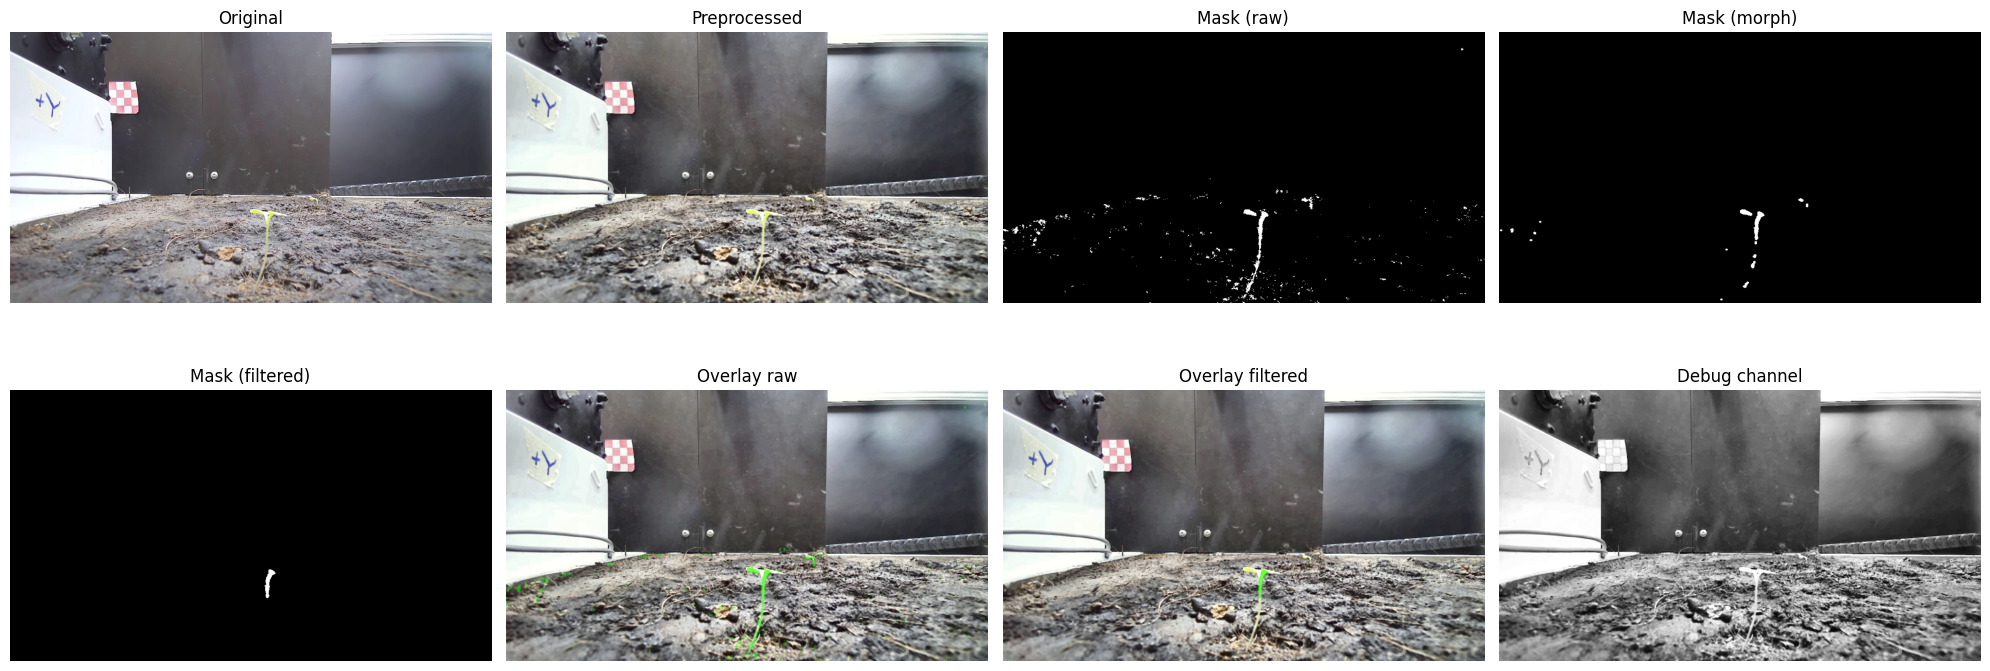

Text(0.5, 1.0, 'Components kept: 1')

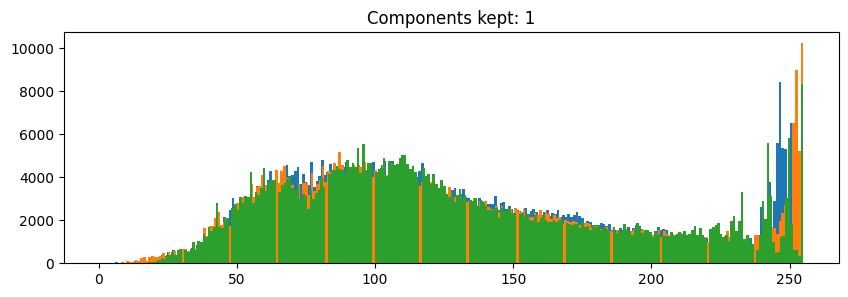

In [13]:
img0 = imread(IMG_PATH)
assert img0 is not None, f"img not found: {IMG_PATH}"

im, m1, m2, m3, dbg, ncomp = preprocess(img0)

ov_raw = overlay(im, m1)
ov_clean = overlay(im, m3)

show_grid(
    [img0, im, m1, m2, m3, ov_raw, ov_clean, dbg],
    ["Original", "Preprocessed", "Mask (raw)", "Mask (morph)",
     "Mask (filtered)", "Overlay raw", "Overlay filtered", "Debug channel"],
    cols=4
)

b,g,r = cv2.split(im)
plt.figure(figsize=(10,3))
plt.hist(b.ravel(), bins=256); plt.hist(g.ravel(), bins=256); plt.hist(r.ravel(), bins=256)
plt.title(f"Components kept: {ncomp}")

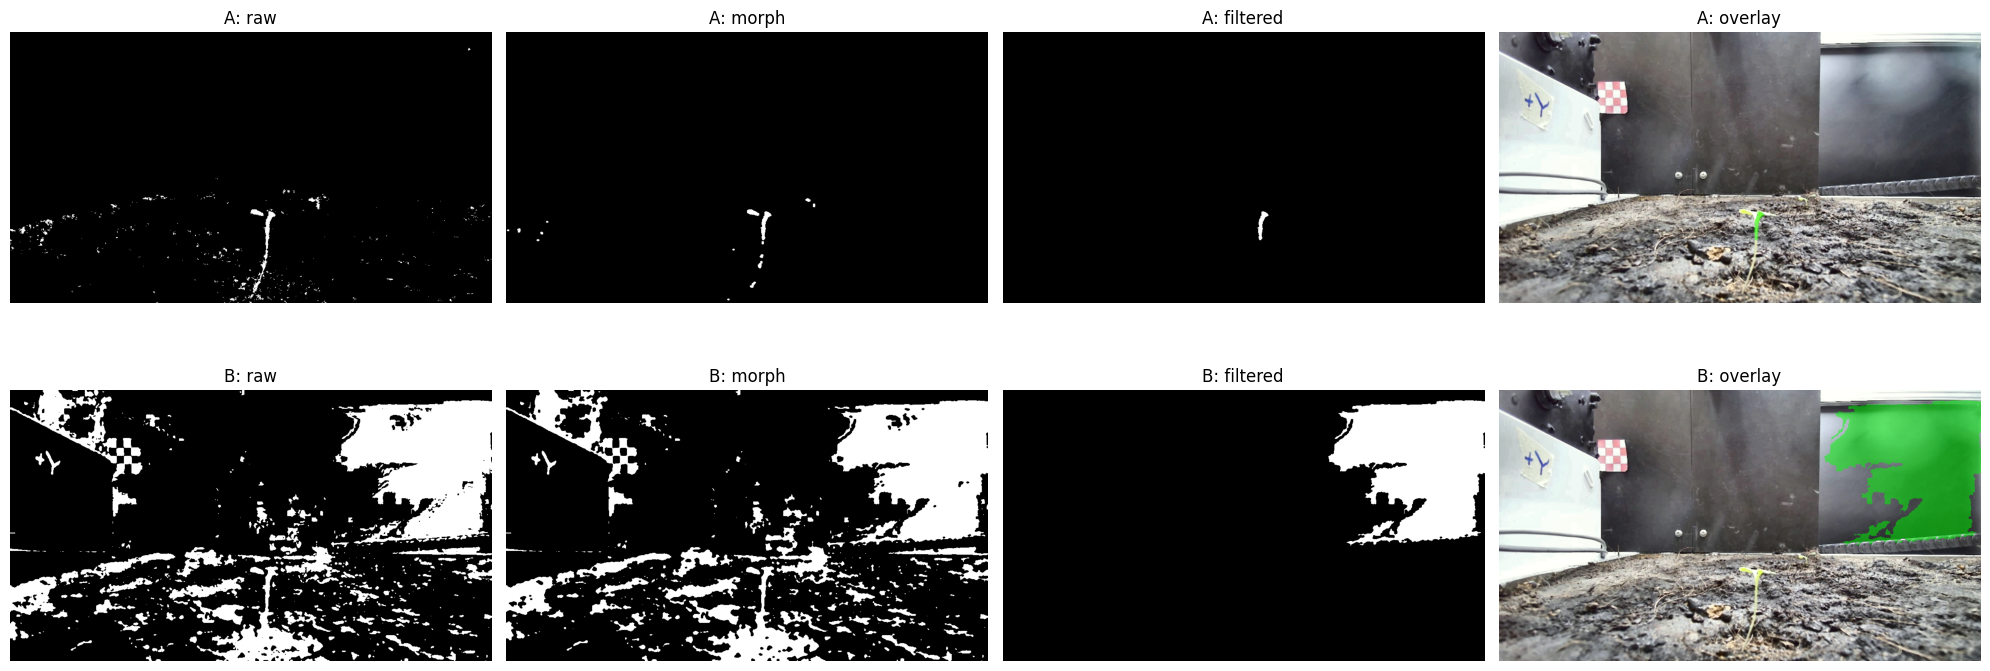

A components: 1  |  B components: 1


In [14]:
A = dict(TH_SPACE="HSV", H_RANGE=(20,95), S_RANGE=(40,255), V_RANGE=(30,255),
         MORPH_OP="open", KERNEL=5, MORPH_IT=1, MIN_AREA=200, KEEP_LARGEST=False)

B = dict(TH_SPACE="S-OTSU", MORPH_OP="close", KERNEL=5, MORPH_IT=1,
         MIN_AREA=300, KEEP_LARGEST=True)

def run_with(params, base_img):
    # อ่านค่าจาก dict (ถ้าไม่กำหนด ใช้ค่ากลางจาก Cell 2)
    th_space = params.get("TH_SPACE", TH_SPACE)
    h_rng    = params.get("H_RANGE", H_RANGE)
    s_rng    = params.get("S_RANGE", S_RANGE)
    v_rng    = params.get("V_RANGE", V_RANGE)
    a_rng    = params.get("A_RANGE", A_RANGE)
    b_rng    = params.get("B_RANGE", B_RANGE)
    morph_op = params.get("MORPH_OP", MORPH_OP)
    kernel   = params.get("KERNEL", KERNEL)
    mit      = params.get("MORPH_IT", MORPH_IT)
    min_area = params.get("MIN_AREA", MIN_AREA)
    keep1    = params.get("KEEP_LARGEST", KEEP_LARGEST)

    # คงขั้นตอน preprocess แบบเดียวกับ Cell 3/4
    im = resize_image(base_img, RESIZE_MODE, MAX_SIDE, TARGET_W)
    if USE_MEDIAN: im = cv2.medianBlur(im, MEDIAN_K)
    elif USE_GAUSS: im = cv2.GaussianBlur(im, (GAUSS_K,GAUSS_K), 0)
    if USE_GRAYWORLD: im = grayworld_wb(im)
    if USE_CLAHE: im = apply_clahe_bgr(im, CLAHE_CLIP, CLAHE_TILE)

    m1, dbg = threshold_mask(im, th_space, h_rng, s_rng, v_rng, a_rng, b_rng)
    m2 = morph(m1, morph_op, kernel, mit)
    m3, ncomp = filter_area(m2, min_area, keep1)
    return im, m1, m2, m3, ncomp

# รันเทียบ A/B
imA, m1A, m2A, m3A, nA = run_with(A, img0)
imB, m1B, m2B, m3B, nB = run_with(B, img0)

show_grid(
    [m1A, m2A, m3A, overlay(imA, m3A),
     m1B, m2B, m3B, overlay(imB, m3B)],
    ["A: raw","A: morph","A: filtered","A: overlay",
     "B: raw","B: morph","B: filtered","B: overlay"],
    cols=4
)
print(f"A components: {nA}  |  B components: {nB}")


In [15]:
import cv2, numpy as np, matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['axes.grid'] = False

def imread(path):
    p = str(path)
    img = cv2.imdecode(np.fromfile(p, dtype=np.uint8), cv2.IMREAD_COLOR)
    return img if img is not None else cv2.imread(p, cv2.IMREAD_COLOR)

def show_grid(imgs, titles, cols=4):
    n = len(imgs); rows = (n+cols-1)//cols
    plt.figure(figsize=(5*cols, 4*rows))
    for i, im in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        if im.ndim == 2: plt.imshow(im, cmap='gray')
        else: plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
        plt.title(titles[i]); plt.axis('off')
    plt.tight_layout(); plt.show()

def grayworld(img):
    x = img.astype(np.float32)
    b,g,r = cv2.split(x)
    mb,mg,mr = [c.mean()+1e-6 for c in (b,g,r)]
    k = (mb+mg+mr)/3
    b *= k/mb; g *= k/mg; r *= k/mr
    return np.clip(cv2.merge([b,g,r]),0,255).astype(np.uint8)

def clahe_bgr(img, clip=2.0, tile=8):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(tile,tile))
    L2 = clahe.apply(L)
    return cv2.cvtColor(cv2.merge([L2,a,b]), cv2.COLOR_LAB2BGR)


In [16]:
# Resize
MAX_SIDE = 800

# Blur
GAUSS_K  = 3
MEDIAN_K = 5

# CLAHE
CLAHE_CLIP = 2.0
CLAHE_TILE = 8

# HSV Mask
H_RANGE = (20, 95)
S_RANGE = (40, 255)
V_RANGE = (30, 255)

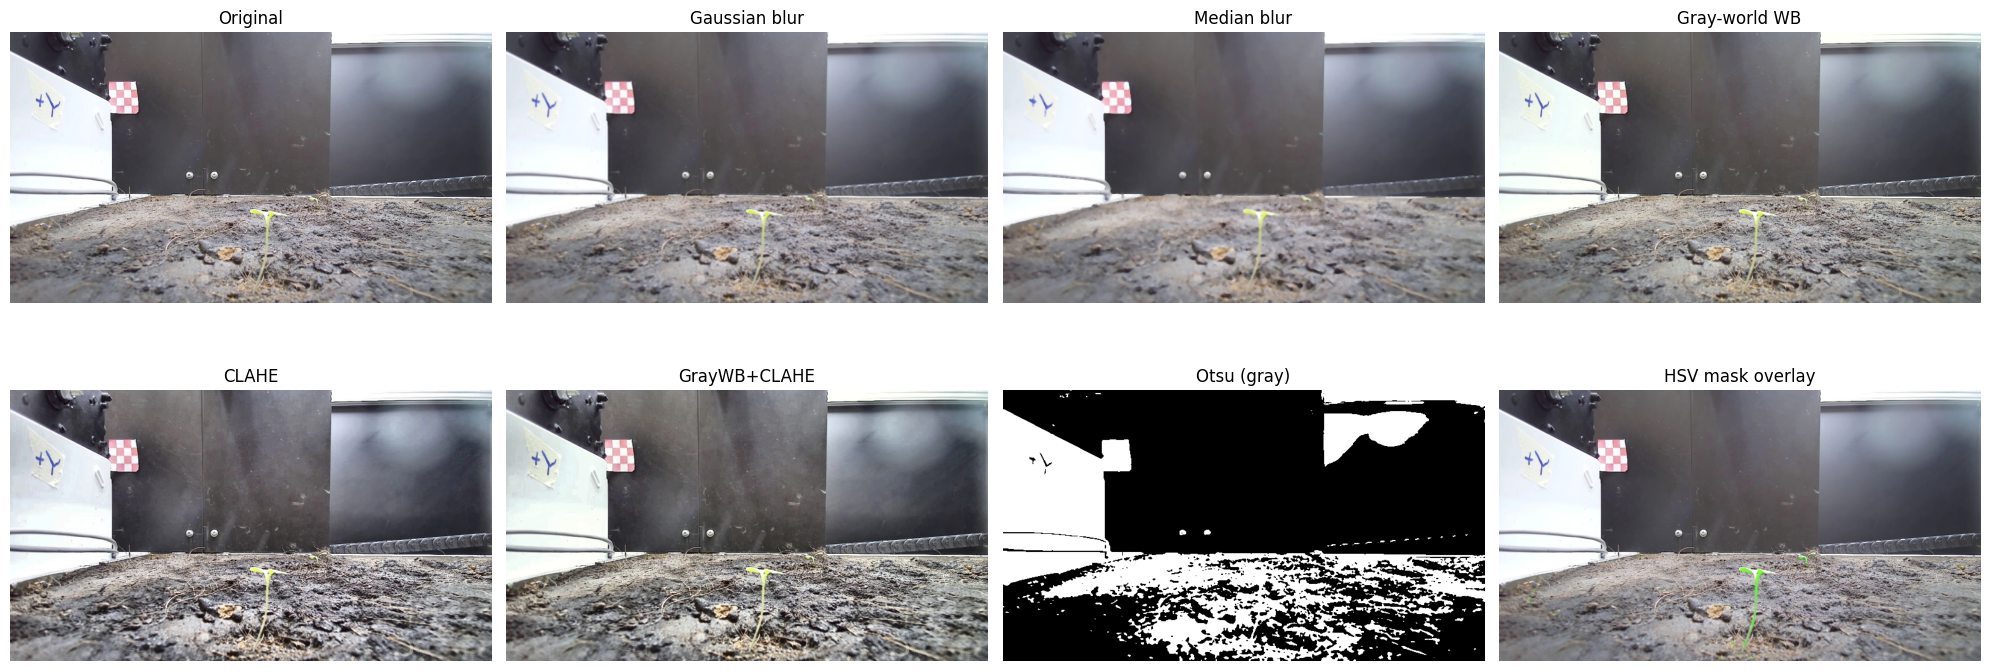

In [17]:
img0 = imread(IMG_PATH)
assert img0 is not None, "ไม่พบรูป!"

# resize (ถ้าใหญ่เกิน)
h,w = img0.shape[:2]
scale = MAX_SIDE / max(h,w)
if scale < 1.0:
    img = cv2.resize(img0, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_AREA)
else:
    img = img0.copy()

# 1) Gaussian blur
gauss = cv2.GaussianBlur(img, (GAUSS_K,GAUSS_K), 0)

# 2) Median blur
median = cv2.medianBlur(img, MEDIAN_K)

# 3) Gray-world WB
graywb = grayworld(img)

# 4) CLAHE
clahe = clahe_bgr(img, CLAHE_CLIP, CLAHE_TILE)

# 5) CLAHE + Gray-world (รวม)
combo = clahe_bgr(grayworld(img))

# 6) Grayscale + Otsu
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
_, otsu = cv2.threshold(cv2.GaussianBlur(gray,(5,5),0), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# 7) HSV mask
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask_hsv = cv2.inRange(hsv, (H_RANGE[0], S_RANGE[0], V_RANGE[0]), (H_RANGE[1], S_RANGE[1], V_RANGE[1]))

# 8) Overlay mask
overlay = img.copy()
overlay[mask_hsv>0] = (0,255,0)
overlay = cv2.addWeighted(img,0.6,overlay,0.4,0)

show_grid(
    [img0, gauss, median, graywb, clahe, combo, otsu, overlay],
    ["Original","Gaussian blur","Median blur","Gray-world WB",
     "CLAHE","GrayWB+CLAHE","Otsu (gray)","HSV mask overlay"],
    cols=4
)
